<a href="https://colab.research.google.com/github/Souguiroumaima7/facial-recognition-system/blob/main/face_detection%2BEmotions%20FINAL%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
#import libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import subprocess
import os
import time
os.environ['WANDB_NOTEBOOK_NAME'] = 'EmotionClassifier'
from keras.models import sequential 
from keras.layers import Dense, Dropout,Flatten 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D  
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import argparse
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [2]:
def take_photo(filename='image2.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [3]:
image_file = take_photo()

<IPython.core.display.Javascript object>

400 300


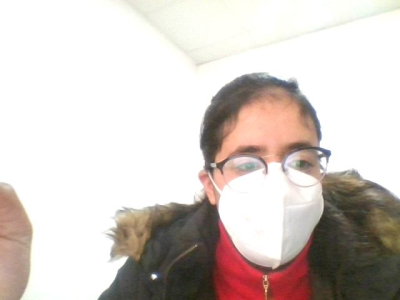

In [4]:
#image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
image = cv2.imread(image_file)

# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

In [ ]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

In [ ]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

In [7]:
# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [ ]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

In [9]:
for i in range(0, detections.shape[2]):

	# extract the confidence (i.e., probability) associated with the prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the `confidence` is
	# greater than the minimum confidence threshold
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# draw the bounding box of the face along with the associated probability
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

In [ ]:
cv2_imshow(image)

In [11]:
 emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [ ]:
%cd facial_expressions/
%mkdir -p data_set/{anger,happy,neutral,sad,surprise}

In [13]:
from skimage.io import imread
data = imread(image_file)

In [14]:
def load_dataset():
    import csv
    with  open(image_file,'r') as f:
        data=csv.reader(f)
        X=[]
        Y=[]
        i=1
        for row in data:
            if i:    #skip first row (header)
                i=0
                continue    
            Y.append(int(row[0]))
            X.append([int(n) for n in row[1].split(' ')])
    return (np.array(X),np.array(Y))

In [15]:
def create_model():
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input,Conv2D,Dense,BatchNormalization,Activation
    from tensorflow.keras.layers import Dropout,MaxPooling2D,AveragePooling2D,Flatten

    inputs=Input(shape=(48,48,1))

    X=Conv2D(filters=32,kernel_size=(7,7),padding='same')(inputs)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((2,2))(X)
    X=Dropout(.25)(X)

    X=Conv2D(filters=64,kernel_size=(3,3),padding='same')(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((2,2))(X)
    X=Dropout(.25)(X)

    X=Conv2D(filters=128,kernel_size=(3,3),padding='same')(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((2,2))(X)
    X=Dropout(.25)(X)  

    X=Conv2D(filters=256,kernel_size=(3,3),padding='same')(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=AveragePooling2D((6,6))(X) 
    X=Dropout(.25)(X)

    X=Flatten()(X)
    X=Dense(256)(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=Dropout(.25)(X)

    X=Dense(128)(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=Dropout(.25)(X)

    X=Dense(7,'softmax')(X)

    model=Model(inputs=inputs,outputs=X)
    return model
    

In [ ]:
load_pretrained_model=True

if load_pretrained_model: 
    from tensorflow.keras.models import load_model 
    print('model is loaded successfully')
    
else:
    #create model with 4 conv layers and 2 FC layers
    model=create_model() 

    #compile the model
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

    #train the model
    num_iterations=114   
    model.fit(X_train,Y_train_oh,batch_size=64,epochs=num_iterations,validation_split=0.08,verbose=2)
    
    #save model  
    model.save(image,save_format='jpg')
    
    print('model is trained and saved successfully')



In [17]:
import cv2
image_file = cv2.imread("image2.jpg")


In [ ]:
import matplotlib.pyplot as plt 
plt = cv2_imshow(image_file)


In [ ]:
pip install deepface

In [ ]:
from deepface import DeepFace
predictions = DeepFace.analyze("image2.jpg")

In [ ]:
predictions

In [ ]:
type(predictions)

In [ ]:
predictions['dominant_emotion']

In [ ]:
from deepface import DeepFace
obj = DeepFace.analyze(img_path = "image2.jpg", actions = ['age', 'gender', 'race', 'emotion'])

In [25]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")

In [ ]:
gray = cv2.cvtColor(image_file,cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(gray, 1.3, 5, 0)
print (faces)
for(x,y,w,h) in faces:
 cv2.rectangle(image_file, (x,y), (x+w,y+h), (0,255,0), 2)


In [ ]:
cv2_imshow(cv2.cvtColor(image_file,cv2.COLOR_BGR2BGRA))


In [39]:
font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(image_file,
            predictions['dominant_emotion'],
            (0,50),
            font, 1,
            (0,0,255),
            2,
            cv2.LINE_8) ;


In [ ]:
cv2_imshow(cv2.cvtColor(image_file, cv2.COLOR_BGR2BGRA))